# Live plot of multiple temperature sources simultaneously

The goal of this notebook is to record and plot multiple temperature sources simultaneously. Global variables can be used to set both the data sources and their configuration options.

With the global variable `ENABLED_CSV_LOGGING` the recording of the measurement series is activated. The recording of given data frames is done in the class `Log2CSV` created especially for this task.
To avoid premature wear of flash memory (e. g. microSD cards) by permanent writing of files, the incoming data is first collected in an internal buffer data frame and only written to the CSV file after a predefined time interval.

## Global settings

### Load globally used libraries and set plot parameters

In [1]:
# Enabling the `widget` backend.
# This requires jupyter-matplotlib a.k.a. ipympl.
# ipympl can be installed via pip or conda.
# for more details, see: https://github.com/matplotlib/ipympl
%matplotlib widget

import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import pandas as pd
import numpy as np

# import classes from external python files
import importlib.util

import time
import datetime

### Global variables for the selection of data sources

In [2]:
# flags to activate/deactivate temperature measurement sources
ENABLED_KEYSIGHT_DMM = True
ENABLED_DS18B20_GPIO = True
ENABLED_BME280_I2C = True
ENABLED_OPUS20 = False

ENABLED_CSV_LOGGING = True

# initialize the array storing the labels of temperature measurement sources
temp_measurement_sources_arr = []
sensor_number = 0

### Global configuration of the data sources

In [3]:
if ENABLED_CSV_LOGGING:
    # class Log2CSV has to imported via importlib due to different path of notebook and class file
    spec = importlib.util.spec_from_file_location("Log2CSV", "./Log2CSV_class.py")
    log2csv_class = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(log2csv_class)
    
    # every 60 seconds the internal data frame buffer should be written to the CSV file
    CSV_LOGGING_INTERVALL = 60

In [4]:
if ENABLED_KEYSIGHT_DMM:
    KEYSIGHT_IP = '192.168.12.154'
    #KEYSIGHT_IP = '192.168.10.113'
    KEYSIGHT_TEMP_CONF = '01_PT100_4WIRE'
    #KEYSIGHT_TEMP_CONF = '02_PT1000_2WIRE'
    sensor_number += 1
    KEYSIGHT_TEMP_LABEL = 'Sensor ' + str(sensor_number) + ': Pt100-4wire @Keysight'
    #KEYSIGHT_TEMP_LABEL = 'Sensor ' + str(sensor_number) + ': Pt1000-2wire @Keysight'
    
    temp_measurement_sources_arr.append(KEYSIGHT_TEMP_LABEL)

In [5]:
if ENABLED_BME280_I2C:
    # i2c bus device /dev/i2c-11 or /dev/i2c-22
    BME280_I2C_BUS_DEV = 22
    # i2c address of BME280 on i2c bus
    BME280_I2C_ADDR = 0x76
    sensor_number += 1
    BME280_TEMP_LABEL = 'Sensor ' + str(sensor_number) + ': BME280 @I2C'
    
    temp_measurement_sources_arr.append(BME280_TEMP_LABEL)

In [6]:
if ENABLED_DS18B20_GPIO:
    from w1thermsensor import W1ThermSensor, Sensor
    
    # connect to DS18B20 sensors
    sensor_obj = W1ThermSensor()
    sensor_list = sensor_obj.get_available_sensors([Sensor.DS18B20])
    
    for sensor in sensor_list:
        sensor_number += 1
        DS18B20_GPIO_TEMP_LABEL = 'Sensor ' + str(sensor_number) + ': DS18B20 @GPIO'
        temp_measurement_sources_arr.append(DS18B20_GPIO_TEMP_LABEL)

In [7]:
if ENABLED_OPUS20:
    OPUS20_IP = '192.168.10.157'
    sensor_number += 1
    OPUS20_TEMP_LABEL = 'Sensor ' + str(sensor_number) + ': OPUS20 @LAN'
    
    temp_measurement_sources_arr.append(OPUS20_TEMP_LABEL)

In [8]:
temp_measurement_sources_arr

['Sensor 1: Pt100-4wire @Keysight',
 'Sensor 2: BME280 @I2C',
 'Sensor 3: DS18B20 @GPIO',
 'Sensor 4: DS18B20 @GPIO']

In [9]:
if ENABLED_KEYSIGHT_DMM:
    # import wrapper class PyVisa_Keysight_34465A from python file PyVisa_Keysight_34465A_class.py
    # from ../PyVisa_Keysight_34465A_class.py import PyVisa_Keysight_34465A

    # class PyVisa_Keysight_34465A has to imported via importlib due to different path of notebook and class file
    spec = importlib.util.spec_from_file_location("PyVisa_Keysight_34465A", "./PyVisa_Keysight_34465A_class.py")
    keysight_class = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(keysight_class)

In [10]:
if ENABLED_BME280_I2C:
    import smbus2
    import bme280

In [11]:
if ENABLED_OPUS20:
    from opus20 import Opus20, OPUS20_CHANNEL_SPEC

## Live plot of multiple temperature sources

### Creating the chart canvas for the live plot

In [12]:
def dataframe_add_row(df=None, row=[]):
    if (df is None):
        return
    
    # add a row
    df.loc[-1] = row
    
    # shift the index
    df.index = df.index + 1
    
    # reset the index of dataframe and avoid the old index being added as a column
    df.reset_index(drop=True, inplace=True)

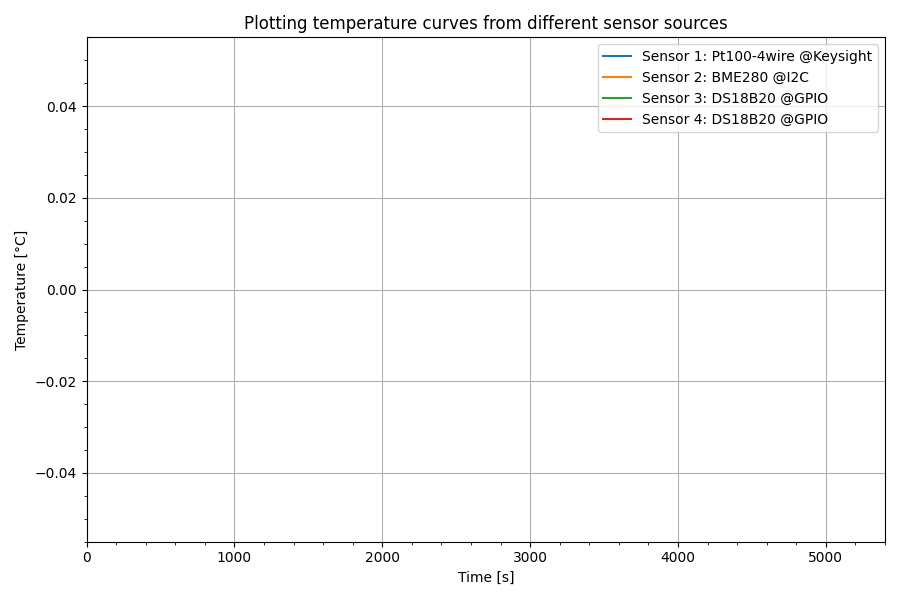

In [13]:
INTERVAL = 0.5

if ENABLED_DS18B20_GPIO:
    # initialization of the temperature array in size according to the number of sensors
    temp_array = np.empty(len(sensor_list), dtype=object)

if ENABLED_KEYSIGHT_DMM:
    # create new device object for the digital multimeter (DMM) Keysight 34465A
    dmm = keysight_class.PyVisa_Keysight_34465A(tcp_ip = KEYSIGHT_IP)

    # configure Keysight DMM for temperature measurement with a valid configuration
    dmm.confTempMeasure(KEYSIGHT_TEMP_CONF)

if ENABLED_BME280_I2C:
    i2c_bus_dev = smbus2.SMBus(BME280_I2C_BUS_DEV)
    bme280_calibration_params = bme280.load_calibration_params(i2c_bus_dev, BME280_I2C_ADDR)

if ENABLED_OPUS20:
    o20 = Opus20(OPUS20_IP)

# get starting time
time_start_sec = float("{:.2f}".format(time.time()))

# initialize the dataframe that will store the measured values using the column labels of 
# activated temperature measurement sources
df_meas_values = pd.DataFrame(columns=['Time [s]'])

for idx, label in enumerate(temp_measurement_sources_arr):
    df_meas_values.insert(idx+1, label+' [°C]', '')

if ENABLED_CSV_LOGGING:
    str_csv_file = time.strftime('./data_files/' + '%Y-%m-%d_%H_%M') + '_TemperatureLivePlot.tsv'
    
    list_csv_header = ['Time [s]']
    for idx, label in enumerate(temp_measurement_sources_arr):
        list_csv_header.append(label+' [°C]')
    
    # create csv logging object
    csvLogger = log2csv_class.Log2CSV(str_csv_file, CSV_LOGGING_INTERVALL, list_csv_header)

plt.ioff()

fig, ax = plt.subplots(figsize=(9,6))
fig.canvas.header_visible = False
fig.canvas.layout.min_height = '400px'

plt.title('Plotting temperature curves from different sensor sources')

# define the limits of the x-axis in seconds, from when the canvas should be scrolled
xlim_left = 0
#xlim_span = 600  # 10 minutes
#xlim_span = 1800 # 0.5 h
xlim_span = 5400 # 1.5 h
xlim_right = xlim_left + xlim_span
xlim_scroll = xlim_span - 10

ax.set_xlim(xlim_left, xlim_right)

# create list of line objects
line_objects_arr = []
for idx, val in enumerate(temp_measurement_sources_arr):
    line_objects_arr.append('line_temp_'+str(idx))

# dynamically create line objects by list
for idx, val in enumerate(line_objects_arr):
    line_objects_arr[idx], = ax.plot(df_meas_values['Time [s]'], 
                                     df_meas_values[temp_measurement_sources_arr[idx]+' [°C]'], 
                                     label=temp_measurement_sources_arr[idx])

ax.grid(True)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Temperature [°C]')
ax.minorticks_on()

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

plt.legend()
plt.tight_layout()

fig.canvas.draw()
fig.canvas.flush_events()

display(fig.canvas)

### Endless loop for data acquisition and display in live plot

In [14]:
#display(fig.canvas)

while True:
    try:
        # get time relative to starting time and round to 2 decimals
        timestamp_sec = float("{:.2f}".format(time.time() - time_start_sec))
        # convert timestamp in seconds to human readable time string
        timestamp_str = str(datetime.timedelta(seconds=timestamp_sec))

        values_row = [timestamp_sec]
        
        if ENABLED_KEYSIGHT_DMM:
            # retrieve temperature values from Keysight DMM
            temp_dmm = dmm.getMeasurement()
            print("<{}>\t Pt100 Temperature: {:.7f} °C".format(timestamp_str, temp_dmm))
            values_row.append(temp_dmm)
            
        if ENABLED_BME280_I2C:
            # the sample method will take a single reading and return
            # a compensated_reading object
            bme280_data = bme280.sample(i2c_bus_dev, BME280_I2C_ADDR, bme280_calibration_params)
            print("<{}>\t BME280 Temperature: {:.7f} °C".format(timestamp_str, bme280_data.temperature))
            values_row.append(bme280_data.temperature)
        
        if ENABLED_DS18B20_GPIO:
            i = 0
            for sensor in sensor_list:
                temp_array[i] = sensor.get_temperature()
                print("<{}>\t DS18B20 Sensor: {:d} of {:d}, Temperature: {:.3f} °C, ID: {}"
                      .format(timestamp_str, i+1, len(sensor_list), temp_array[i], sensor.id))
                values_row.append(temp_array[i])
                i += 1

        if ENABLED_OPUS20:
            # retrieve temperature values from OPUS20 (channel '100' holds current temperature)
            temp_o20 = o20.multi_channel_value([100])
            print("<{}>\t OPUS20 Temperature: {:.7f} °C".format(timestamp_str, temp_o20[0]))
            values_row.append(temp_o20[0])
                
        dataframe_add_row(df_meas_values, values_row)
        
        if ENABLED_CSV_LOGGING:
            # log row to csv file
            csvLogger.log_data(values_row)

        # when the right edge of the canvas is reached, the canvas should continue to scroll to the left
        xlim_right = datetime.timedelta(seconds=df_meas_values['Time [s]'][0]) \
                     + datetime.timedelta(seconds=xlim_scroll)
        if (timestamp_sec >= xlim_right.total_seconds()):
            # drop first row of dataframe
            df_meas_values.drop(index=df_meas_values.head(1).index, inplace=True)
            # reset index of dataframe
            df_meas_values.reset_index(inplace=True, drop=True)

            # take the new first time value for the left boundary of the x-axis
            xlim_left = df_meas_values['Time [s]'][0]
            xlim_right = xlim_left + xlim_span
            ax.set_xlim(xlim_left, xlim_right)

        # Manual scaling of the y-axis
        # get MIN and MAX values of the whole data frame
        min_val_series = df_meas_values.min()
        max_val_series = df_meas_values.max()
        # drop first elements of the series, because it's the time in seconds and not relevant
        min_val_series.drop(min_val_series.index[0], inplace=True)
        max_val_series.drop(max_val_series.index[0], inplace=True)
        # add some space beneath min value and above max value (in °C)
        ylim_min = min_val_series.min() - 1.5
        ylim_max = max_val_series.max() + 1.5
        # set new scale of y-axis
        ax.set_ylim(ylim_min, ylim_max)
        
        # iterate over the list holding the line objects and set new x- and y-values
        for idx, val in enumerate(line_objects_arr):
            line_objects_arr[idx].set_xdata(df_meas_values['Time [s]'])
            line_objects_arr[idx].set_ydata(df_meas_values[temp_measurement_sources_arr[idx]+' [°C]'])

        #ax.relim()
        #ax.autoscale_view()

        fig.canvas.draw()
        fig.canvas.flush_events()

        time.sleep(INTERVAL)
        
    except:
        if ENABLED_KEYSIGHT_DMM:
            dmm.closeConnection()
        
        # The OPUS20 takes it very badly if the connection is not disconnected cleanly ...
        if ENABLED_OPUS20:
            o20.disconnect()
        
        print("Keyboard Interrupt ^C detected.")
        print("Bye.")
        break

<0:00:03.110000>	 Pt100 Temperature: 18.7034675 °C
<0:00:03.110000>	 BME280 Temperature: 18.7668260 °C
<0:00:03.110000>	 DS18B20 Sensor: 1 of 2, Temperature: 18.375 °C, ID: 012116c9fc70
<0:00:03.110000>	 DS18B20 Sensor: 2 of 2, Temperature: 18.125 °C, ID: 01202ceb55a3
<0:00:06.340000>	 Pt100 Temperature: 18.7042194 °C
<0:00:06.340000>	 BME280 Temperature: 18.7567542 °C
<0:00:06.340000>	 DS18B20 Sensor: 1 of 2, Temperature: 18.375 °C, ID: 012116c9fc70
<0:00:06.340000>	 DS18B20 Sensor: 2 of 2, Temperature: 18.125 °C, ID: 01202ceb55a3
<0:00:09.510000>	 Pt100 Temperature: 18.7043598 °C
<0:00:09.510000>	 BME280 Temperature: 18.7567542 °C
<0:00:09.510000>	 DS18B20 Sensor: 1 of 2, Temperature: 18.375 °C, ID: 012116c9fc70
<0:00:09.510000>	 DS18B20 Sensor: 2 of 2, Temperature: 18.125 °C, ID: 01202ceb55a3
<0:00:12.660000>	 Pt100 Temperature: 18.7050793 °C
<0:00:12.660000>	 BME280 Temperature: 18.7668260 °C
<0:00:12.660000>	 DS18B20 Sensor: 1 of 2, Temperature: 18.375 °C, ID: 012116c9fc70
<0:00:1

In [15]:
df_meas_values

,Time [s],Sensor 1: Pt100-4wire @Keysight [°C],Sensor 2: BME280 @I2C [°C],Sensor 3: DS18B20 @GPIO [°C],Sensor 4: DS18B20 @GPIO [°C]
0,5269.44,26.599905,22.553915,25.6250,24.7500
1,5272.61,26.509425,22.422975,25.5000,24.6875
2,5275.73,26.417700,22.281964,25.4375,24.6250
3,5278.86,26.331972,22.171170,25.3750,24.5625
4,5281.98,26.245661,22.015050,25.3125,24.5000
...,...,...,...,...,...
1719,10775.34,18.919847,18.323667,18.5625,18.3750
1720,10778.54,18.920073,18.328703,18.5625,18.3750
1721,10781.63,18.919216,18.323667,18.5625,18.3750
1722,10784.80,18.920372,18.323667,18.5625,18.3750


In [169]:
o20.disconnect()